# Big Mart Sales Prediction(Regression)
 Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a regression problem. Predict the sales of store


## We will explore the problem in following stages:
### 1.Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
### 2.Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
### 3.Data Cleaning – imputing missing values in the data and checking for outliers
### 4.Feature Engineering – modifying existing variables and creating new ones for analysis
### 5.Model Building – making predictive models on the data 

In [1]:
import pandas as pd
import numpy as np

## Data Exploration

In [2]:
train =pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train['source']='train'
test['source']='test'
df=pd.concat([train,test],ignore_index=True)
print (train.shape,test.shape,df.shape)

(8523, 13) (5681, 12) (14204, 13)


### Missing Values

In [4]:
df.apply(lambda x:sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [5]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
df.apply(lambda x:len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [7]:
#Filter categorical variables
categorical_columns=[x for x in df.dtypes.index if df.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns=[x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (df[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

## Data Cleaning
### Imputting Missing Values

In [8]:
#Determine the average weight per item:
item_avg=df.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss=df['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss))
df.loc[miss,'Item_Weight']=df.loc[miss,'Item_Identifier'].apply(lambda x: item_avg.loc[x])
print (sum(df['Item_Weight'].isnull()))


Orignal #missing: 2439
0


In [9]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode=df.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = df['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(df['Outlet_Size'].isnull()))


Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 4016
0


## Feature Engineering

In [10]:
df.pivot_table(values="Item_Outlet_Sales",index="Outlet_Type")

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


In [11]:
#Determine avg visibility of product (as some has min 0)
avg=df.pivot_table(values="Item_Visibility",index="Item_Identifier")

#impute 0 with avg visibilty of that product
miss=(df["Item_Visibility"]==0)

print ('Number of 0 values initially: %d'%sum(miss))
df.loc[miss,'Item_Visibility']=df.loc[miss,'Item_Identifier'].apply(lambda x:avg.loc[x])
print (sum(df['Item_Visibility'] == 0))

Number of 0 values initially: 879
0


In [12]:
#Determine another variable with means ratio
df['Item_Visibility_MeanRatio']=df.apply(lambda x: x['Item_Visibility']/avg.loc[x['Item_Identifier']], axis=1)
print (df['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [13]:
#Get the first two characters of ID:
df['Item_Type_Combined']=df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
df['Item_Type_Combined']=df['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
df['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [14]:
#years
df["Outlet_Year"]=2013-df["Outlet_Establishment_Year"]
df["Outlet_Year"].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Year, dtype: float64

In [15]:
#Change categories of low fat:
print ('Original Categories:')
print (df['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
print (df['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [16]:
#Mark non-consumables as separate category in low_fat:
df.loc[df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content']="Non-Edible"
df['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
#New variable for outlet
df['Outlet']=le.fit_transform(df['Outlet_Identifier'])
df['Item_Fat_Content']=le.fit_transform(df['Item_Fat_Content'].astype('bool'))
var_mod=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le=LabelEncoder()
for i in var_mod:
    df[i]=le.fit_transform(df[i])

In [18]:
#One Hot Coding:
df=pd.get_dummies(df,columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [19]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Year                    int64
Item_Fat_Content_0             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
Outlet_1                       uint8
O

In [20]:
df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)



In [21]:
train = df.loc[df['source']=="train"]
test = df.loc[df['source']=="test"]

In [22]:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)

c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [24]:
train.drop(['source'],axis=1,inplace=True)

In [25]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Identifier             object
Item_Outlet_Sales            float64
Item_Visibility_MeanRatio    float64
Outlet_Year                    int64
Item_Fat_Content_0             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
Outlet_1                       uint8
Outlet_2                       uint8
Outlet_3                       uint8
Outlet_4                       uint8
O

In [26]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']


## Model Building

In [27]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)

c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:

from sklearn.model_selection import cross_val_score
from sklearn import metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score=cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score=np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

## Linear Regression


Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 43.56 | Min - 1075 | Max - 1212


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'Model Coefficients'}>

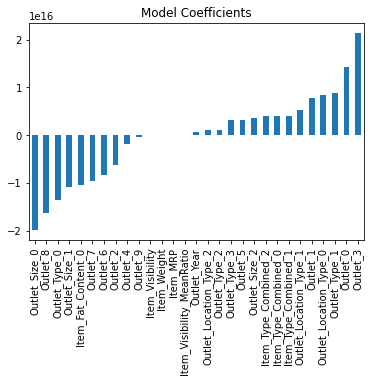

In [29]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
predictor=[x for x in train.columns if x not in [target]+IDcol]
l=LinearRegression(normalize=True)
modelfit(l,train,test,predictor,target, IDcol, 'alg1.csv')
coef1 = pd.Series(l.coef_, predictor).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.71 | Min - 1075 | Max - 1216


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'Model Coefficients'}>

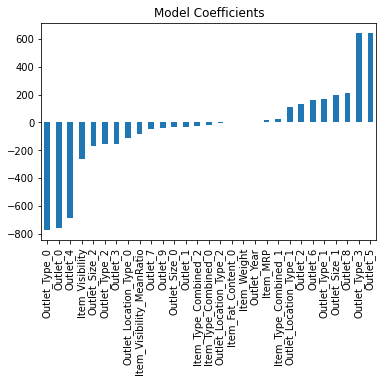

In [30]:
#Ridge Regression
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1057
CV Score : Mean - 1090 | Std - 45.2 | Min - 1001 | Max - 1186


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'Feature Importances'}>

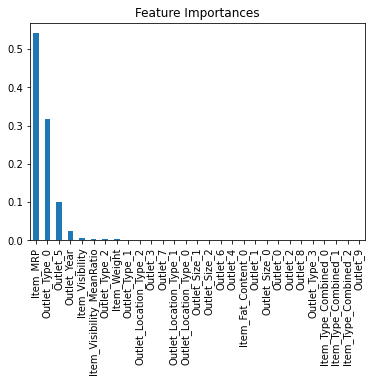

In [31]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1074
CV Score : Mean - 1096 | Std - 43.6 | Min - 1034 | Max - 1174


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'Feature Importances'}>

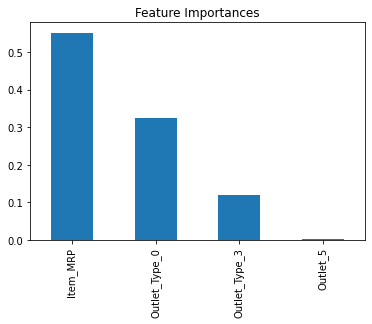

In [32]:
# Decision tree with top 4 variables
predictors=["Item_MRP","Outlet_Type_0","Outlet_5","Outlet_Type_3"]
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.89 | Min - 1020 | Max - 1162


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'Feature Importances'}>

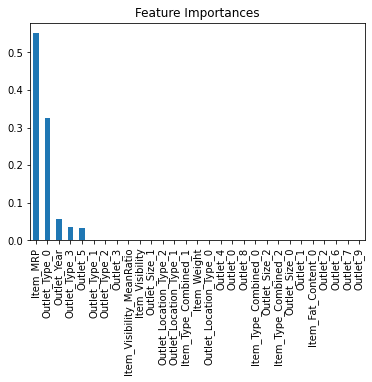

In [33]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

## Conclusion
We started with making some hypothesis about the data without looking at it. Then we moved on to data exploration where we found out some nuances in the data which required remediation. Next, we performed data cleaning and feature engineering, where we imputed missing values and solved other irregularities, made new features and also made the data model-friendly by one-hot-coding. Finally we made regression, decision tree and random forest model and got a glimpse of how to tune them for better results.